https://www.councilofelrond.com/subject/the-fellowship-of-the-ring-2/
<function <lambda> at 0x0000019E1B0B64C8>
{0: [('frodo', 386), ('gandalf', 273), ('ring', 150), ('aragorn', 144), ('sam', 138), ('boromir', 116), ('bilbo', 104), ('pippin', 101), ('merry', 100), ('legolas', 65), ('gimli', 56), ('looks', 54), ('hobbits', 53), ('saruman', 52), ('strider', 47), ('turns', 46), ('fellowship', 45), ('come', 39), ('arwen', 38), ('sauron', 37), ('walks', 35), ('away', 34), ('elrond', 34), ('sword', 34), ('know', 34), ('hand', 33), ('runs', 33), ('look', 33), ('suddenly', 30), ('sees', 29)]}
0
frodo, gandalf, ring, aragorn, sam, boromir, bilbo, pippin, merry, legolas, gimli, looks, hobbits, saruman


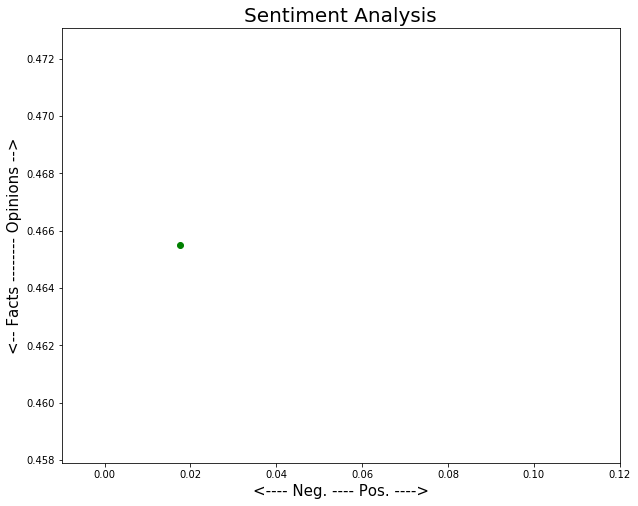

In [41]:
# Web scraping, pickle imports
import requests
from bs4 import BeautifulSoup
import pickle

# Scrapes script data from scrapsfromtheloft.com
def url_to_lotrscript(url):
# Gives me the script from https://www.councilofelrond.com/subject/the-fellowship-of-the-ring-2/
    webpage = requests.get(url).text
    soup = BeautifulSoup(webpage, "lxml")
    text = [p.text for p in soup.find(class_="post-content").find_all('p')]
    print(url)
    return text

# URL of LOTR: The Fellowship of the Ring Script
url_1 = ['https://www.councilofelrond.com/subject/the-fellowship-of-the-ring-2/']

# Name of script for dictionary
lotr_script = ["lotr_script"]

# Request script from website
script = [url_to_lotrscript(x) for x in url_1]

# Here I pickle my script and create a new directory for the script files
for character, lines in enumerate(lotr_script):
    with open("C:/Users/Zachary/Desktop/Python Class/Final Project/Pickled Data" + lines + ".txt", "wb") as file:
        pickle.dump(script[character], file)

# Here we load up pickled files
data = {}
for character, lines in enumerate(lotr_script):
    with open("C:/Users/Zachary/Desktop/Python Class/Final Project/Pickled Data" + lines + ".txt", "rb") as file:
        data[character] = pickle.load(file)

# Double check to make sure data has been loaded properly: data.keys()
# Double check to make sure script loaded properly: data.values()

# Defining function to change the format of the script from a list of text to a string format, giving us one large paragraph of text
def combotext(textlist):
    combotext = ' '.join(textlist)
    return combotext

# Here we make the magic happen
combodata = {key: [combotext(value)] for (key, value) in data.items()}

# Check to make sure everything went smoothly with: print(combodata)

# import panda module for easy application of cleaning functions
import pandas as pd
pd.set_option('max_colwidth',100)

lotr_script = pd.DataFrame.from_dict(combodata).transpose()
lotr_script.columns = ['script']
lotr_script = lotr_script.sort_index()
lotr_script

# Now we start on the cleaning portion of the script. The first round included lowercasing text, removing punctuation and 
# removing words with numbers. Additional rounds included getting rid of ..., additional punctuation, and odd text (/n).
# It is all combined into one for clarity sake.
import re
import string

def scriptcleaner1(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

R1 = lambda x: scriptcleaner1(x)
print(R1)

# Apply all rounds of cleaning
clean_script = pd.DataFrame(lotr_script.script.apply(R1))
# Check to see what it looks like:
clean_script.script.loc[0]

# Pickling the data into a corpus for later use
lotr_script.to_pickle("lotr_corpus.plk")

# For my analysis, I have chosen to put it into a document term matrix as well. This will allow me to tokenize terms to 
# break down the text into words. For this particular analysis,  I have chosen to use CountVectorizer from sci-kit because 
# it allows me to tokenize terms and get rid of stop words that could change my analysis.
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')
data_count_vect = count_vect.fit_transform(clean_script.script)
lotr_doc_matrix = pd.DataFrame(data_count_vect.toarray(), columns=count_vect.get_feature_names())
lotr_doc_matrix.index = clean_script.index
lotr_doc_matrix

# I will also pickle this data for later use
lotr_doc_matrix.to_pickle("lotr_doc_term.pkl")

# Here I will count the top 30 words with the count in the script, along with the top 15 words without the count.
import pandas as pd

data = pd.read_pickle('lotr_doc_term.pkl')
data = data.transpose()
data.head()

top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

print(top_dict)

for top_dict, top_words in top_dict.items():
    print(top_dict)
    print(', '.join([word for word, count in top_words[0:14]]))

# I will now utilize my document term matrix to run my sentiment analysis of my script
import pandas as pd

data = pd.read_pickle('lotr_doc_term.pkl')
data

# Create quick lambda functions to find the polarity and subjectivity of each routine
# I downloaded textblob through conda install -c conda-forge. 
import nltk
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['polarity'] = pd.DataFrame(clean_script.script.apply(pol))
data['subjectivity'] = pd.DataFrame(clean_script.script.apply(sub))
data

# Here I will plot my results of what I found from running the script
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, word in enumerate(data.index):
    x = data.polarity.loc[word]
    y = data.subjectivity.loc[word]
    plt.scatter(x, y, color='green')
    plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<---- Neg. ---- Pos. ---->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()
